In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import re

## Method

Our goal is to check theoretical predictions for the moments/cumulants of $P$ vs. simulation results.

Eq. 48 in manuscript gives the MGF of $P$:

$$
\text{MGF}_P=\text{exp}\left(\mu\rho_N\ell_c^2\sum_{k=0}^\infty\varepsilon^k\hat{u}_k(\vec{0},0)\right)
$$

Truncating the sum at the $j$-th term gives the first $j$ moments.

Truncate at $j=2$:
$$
\text{MGF}_P\approx\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)
$$

### First Moment
$$
\begin{align*}
\mathbb{E}[P] &= \frac{d}{d\varepsilon}\text{MGF}_P\Bigg|_{\varepsilon=0}\\
&=\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\frac{d}{d\varepsilon}\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\\
&=\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\\
&=\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)\right)\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)\right)\right)
\end{align*}
$$

### Second Moment

$$
\begin{align}
\mathbb{E}[P^2]&=\frac{d^2}{d\varepsilon^2}\text{MGF}_P\Bigg|_{\varepsilon=0}\\
&= \frac{d}{d\varepsilon}\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\Bigg|_{\varepsilon=0}\\
&=\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\cdot\left[\mu\rho_N\ell_c^2\left(\hat{u}_1(\vec{0},0)+2\varepsilon\hat{u}_2(\vec{0},0)\right)\right]^2+2\mu\rho_N\ell_c^2\hat{u}_2(\vec{0},0)\cdot\text{exp}\left(\mu\rho_N\ell_c^2\left(\hat{u}_0(\vec{0},0)+\varepsilon\hat{u}_1(\vec{0},0)+\varepsilon^2\hat{u}_2(\vec{0},0)\right)\right)\Bigg|_{\varepsilon=0}\\
&=\text{exp}\left(\mu\rho_N\ell_c^2\hat{u}_0(\vec{0},0)\right)\cdot\left(\mu\rho_N\ell_c^2\hat{u}_1(\vec{0},0)\right)^2+2\mu\rho_N\ell_c^2\hat{u}_2(\vec{0},0)\cdot\text{exp}\left(\mu\rho_N\ell_c^2\hat{u}_0(\vec{0},0)\right)
\end{align}
$$

Note that $\hat{u}_0=0$ and $\hat{u}_1(\vec{0},0)=1$, per methods section. So, these expressions reduce to:

### First Moment 

$$\mathbb{E}[P]=\mu\rho_N\ell_c^2$$

### Second Moment

$$\mathbb{E}[P^2]=\left(\mu\rho_N\ell_c^2\right)^2+2\mu\rho_N\ell_c^2\hat{u}_2(\vec{0},0)$$

## Compare values from theory & simulation

*Note:* Don't have exact match between $w$ values used in theory/sim calcs (can fix in next iteration) but used closest possible values.

In [8]:
### Read in values for \hat{u} terms
# Note u0=0 and u1=1 at origin 
spatial_integrals = pd.read_csv("../../theory/old_files/results/spatial_integrals_dim2.csv")

In [9]:
spatial_integrals

,w,u2_GQ,u3_GQ
0,0.010000,0.489756,1.257117e-01
1,0.010975,0.482353,1.219857e-01
2,0.012045,0.474950,1.183251e-01
3,0.013219,0.467547,1.147210e-01
4,0.014508,0.460144,1.111810e-01
...,...,...,...
95,68.926121,0.000328,9.600560e-08
96,75.646333,0.000273,6.671104e-08
97,83.021757,0.000227,4.621637e-08
98,91.116276,0.000188,3.196808e-08


In [38]:
spatial_integrals.iloc[2,0]

0.0120450354025878

In [17]:
# value closest to 1
spatial_integrals['w'][50]

1.0476157527896652

In [160]:
# value closest to 5
spatial_integrals['w'][67]

5.09413801481638

In [19]:
# value closest to 10
spatial_integrals['w'][74]

9.770099572992256

In [21]:
# value closest to 25
spatial_integrals['w'][84]

24.770763559917118

### $w$=1

In [129]:
files_w1 = glob.glob("../results/gaussian_w1/*_n2_*_L50_*_iter100000000*.sfs")

In [130]:
res = np.zeros((len(files_w1),9))

for i,f in enumerate(files_w1):
    matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w1\.sfs', f)
    s, n, mu, rho, L, maxcount, sigma, seed, iteration, r = matches.groups()
    s = float(s)
    mu = float(mu)
    rho = int(rho)
    sigma = float(sigma)
    
    theory_u2 = spatial_integrals.iloc[50,1]
    
    theory_firstmoment = mu*rho*sigma/s
    
    theory_secondmoment = theory_firstmoment**2 + 2*mu*rho*(sigma/s)*theory_u2
    sim_data = pd.read_csv(f,header=None)
    
    res[i,:] = [s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0]]
    
res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2'])
res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
res['theory_xi2'] = res['theory_secondmoment']

In [131]:
unique_rho_values = sorted(res['rho'].unique())
colors = ['red','blue','green']
color_dict = dict(zip(unique_rho_values, colors))
marker_shapes = ["^",'+','x']

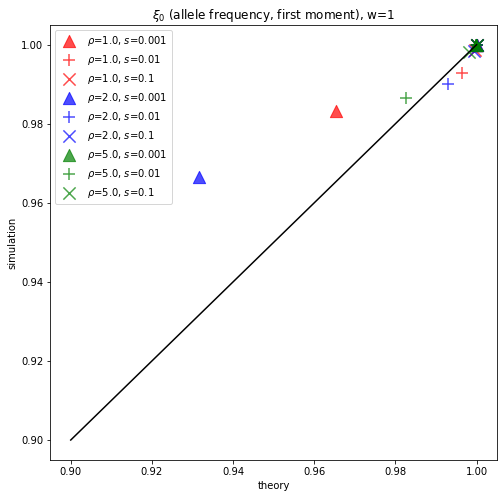

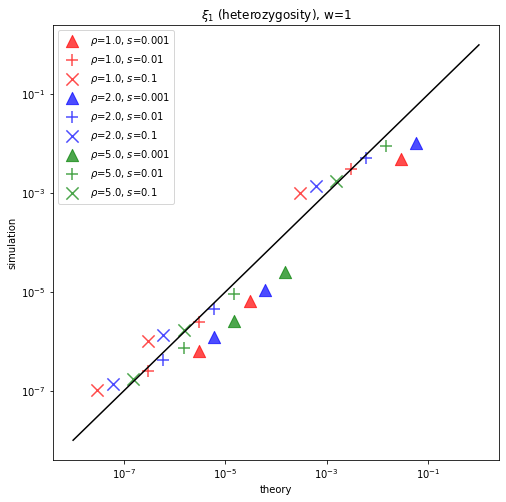

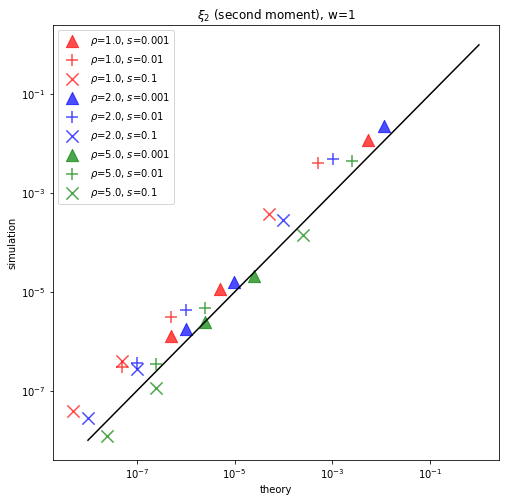

In [132]:
fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.plot(np.linspace(0.9,1),np.linspace(0.9,1),color='black')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_0$ (allele frequency, first moment), w=1")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-8,0),np.logspace(-8,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_1$ (heterozygosity), w=1")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-8,0),np.logspace(-8,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_2$ (second moment), w=1")
plt.show()

In [140]:
files_w5 = glob.glob("../results/gaussian_w5/*_n2_*_L50_*_iter100000000*.sfs")

In [161]:
res = np.zeros((len(files_w5),9))

for i,f in enumerate(files_w5):
    matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w5\.sfs', f)
    s, n, mu, rho, L, maxcount, sigma, seed, iteration, r = matches.groups()
    s = float(s)
    mu = float(mu)
    rho = int(rho)
    sigma = float(sigma)
    
    theory_u2 = spatial_integrals.iloc[67,1]
    
    theory_firstmoment = mu*rho*sigma/s
    
    theory_secondmoment = theory_firstmoment**2 + 2*mu*rho*(sigma/s)*theory_u2
    sim_data = pd.read_csv(f,header=None)
    
    res[i,:] = [s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0]]
    
res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2'])
res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
res['theory_xi2'] = res['theory_secondmoment']

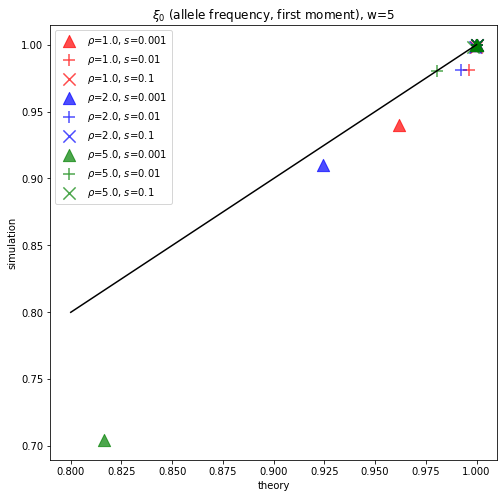

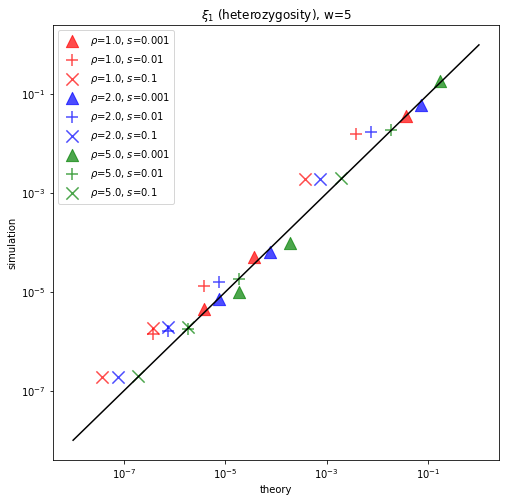

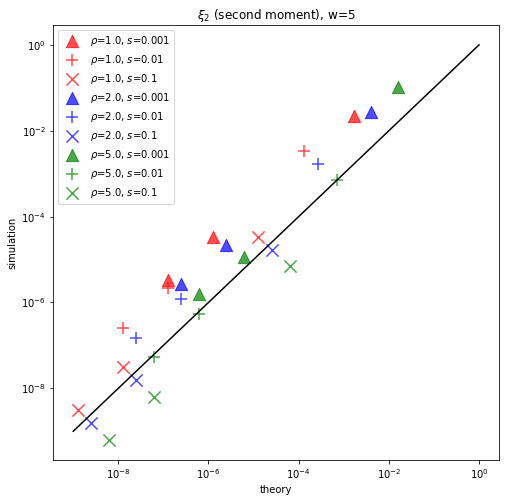

In [162]:
fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.plot(np.linspace(0.8,1),np.linspace(0.8,1),color='black')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_0$ (allele frequency, first moment), w=5")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-8,0),np.logspace(-8,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_1$ (heterozygosity), w=5")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-9,0),np.logspace(-9,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_2$ (second moment), w=5")
plt.show()

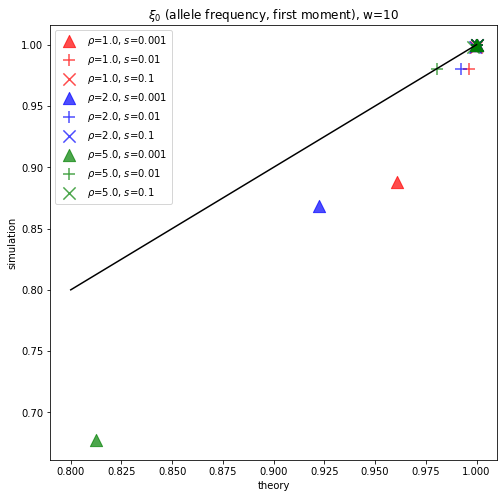

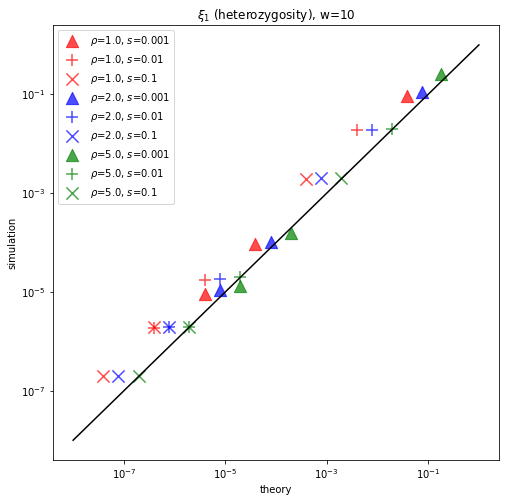

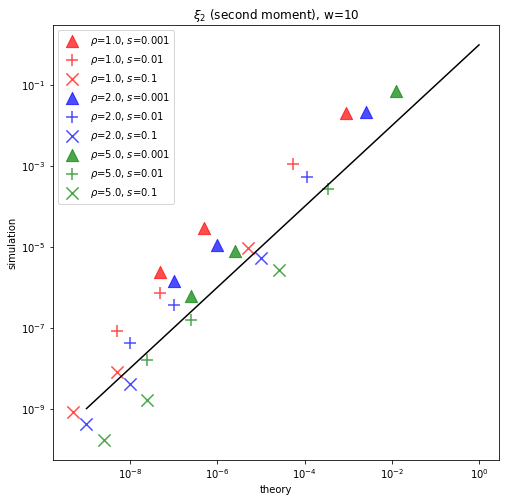

In [164]:
files_w10 = glob.glob("../results/gaussian_w10/*_n2_*_L50_*_iter100000000*.sfs")

res = np.zeros((len(files_w10),9))

for i,f in enumerate(files_w10):
    matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w10\.sfs', f)
    s, n, mu, rho, L, maxcount, sigma, seed, iteration, r = matches.groups()
    s = float(s)
    mu = float(mu)
    rho = int(rho)
    sigma = float(sigma)
    
    theory_u2 = spatial_integrals.iloc[74,1]
    
    theory_firstmoment = mu*rho*sigma/s
    
    theory_secondmoment = theory_firstmoment**2 + 2*mu*rho*(sigma/s)*theory_u2
    sim_data = pd.read_csv(f,header=None)
    
    res[i,:] = [s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0]]
    
res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2'])
res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
res['theory_xi2'] = res['theory_secondmoment']

fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.plot(np.linspace(0.8,1),np.linspace(0.8,1),color='black')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_0$ (allele frequency, first moment), w=10")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-8,0),np.logspace(-8,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_1$ (heterozygosity), w=10")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-9,0),np.logspace(-9,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_2$ (second moment), w=10")
plt.show()

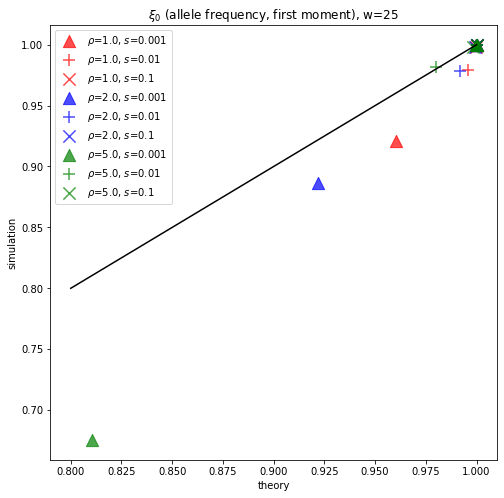

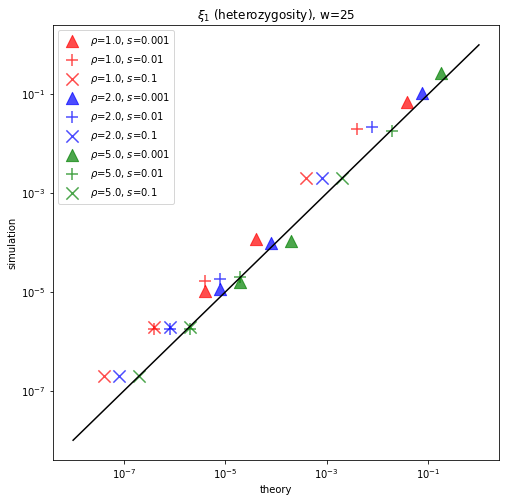

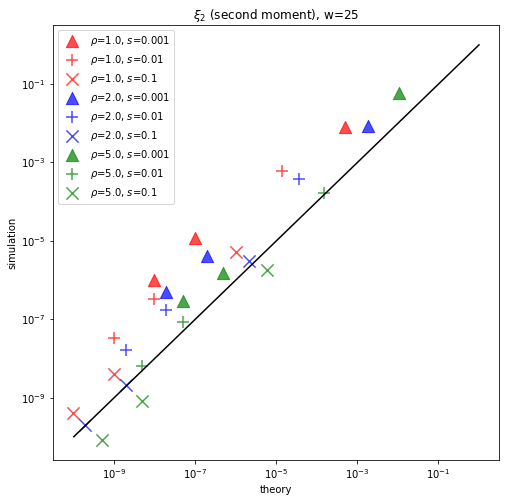

In [166]:
files_w25 = glob.glob("../results/gaussian_w25/*_n2_*_L50_*_iter10000000*.sfs")

res = np.zeros((len(files_w25),9))

for i,f in enumerate(files_w25):
    matches = re.match(r'.*/s([\d.]+)_n(\d+)_mu([\d.e-]+)_rho(\d+)_L(\d+)_maxcount(\d+)_sigma([\d.]+)_seed(\d+)_iter(\d+)_r([\d.]+)_gaussian_w25\.sfs', f)
    s, n, mu, rho, L, maxcount, sigma, seed, iteration, r = matches.groups()
    s = float(s)
    mu = float(mu)
    rho = int(rho)
    sigma = float(sigma)
    
    theory_u2 = spatial_integrals.iloc[84,1]
    
    theory_firstmoment = mu*rho*sigma/s
    
    theory_secondmoment = theory_firstmoment**2 + 2*mu*rho*(sigma/s)*theory_u2
    sim_data = pd.read_csv(f,header=None)
    
    res[i,:] = [s,mu,rho,sigma,theory_firstmoment,theory_secondmoment,sim_data.iloc[0,0],sim_data.iloc[1,0],sim_data.iloc[2,0]]
    
res = pd.DataFrame(res,columns=['s','mu','rho','sigma','theory_firstmoment','theory_secondmoment','xi0','xi1','xi2'])
res['theory_xi0'] = 1-2*res['theory_firstmoment']+res['theory_secondmoment']
res['theory_xi1'] = 2*res['theory_firstmoment']-2*res['theory_secondmoment']
res['theory_xi2'] = res['theory_secondmoment']

fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi0'], res_s['xi0'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.plot(np.linspace(0.8,1),np.linspace(0.8,1),color='black')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_0$ (allele frequency, first moment), w=25")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi1'], res_s['xi1'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-8,0),np.logspace(-8,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_1$ (heterozygosity), w=25")
plt.show()


fig,ax = plt.subplots(figsize=(8,8))

for i, rho_value in enumerate(sorted(res['rho'].unique())):
    res_rho = res[res['rho'] == rho_value]
    for j, s_value in enumerate(sorted(res['s'].unique())):
        res_s = res_rho[res_rho['s'] == s_value]
        ax.scatter(res_s['theory_xi2'], res_s['xi2'], color=color_dict[rho_value], label=r'$\rho$='+str(rho_value)+r', $s$='+str(s_value), marker=marker_shapes[j], s=150, alpha=0.7)

ax.loglog(np.logspace(-10,0),np.logspace(-10,0),color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("theory")
ax.set_ylabel("simulation")
ax.legend()
ax.set_title(r"$\xi_2$ (second moment), w=25")
plt.show()

*Note:* All are 100M iterations except for w=25 (10M iterations)